In [73]:
#matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
import theano.tensor as tt

import data_handling as dh
import bee_util as bu
import functions as ff
import indexTools
import pymc3_utils as pmu

import importlib
importlib.reload(bu)
importlib.reload(ff)
importlib.reload(indexTools)
importlib.reload(dh)
importlib.reload(pmu)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Fit averaged data model

In [4]:
sample=True

In [2]:
from glob import glob
import os
files=sorted(glob("results_analyse/cont_*.csv"))+\
    sorted(glob('results_analyse/caged*.csv'))+\
    sorted(glob('results_analyse/banked*.csv'))

In [3]:
import data_handling as dh
df = dh.read_data(files)

# add integer labels for the various groupings 
df['i_ind'],     df['ucode']   = indexTools.multilabel_encoder(df,'treat day rep string'.split())
df['i_treatday'],df['treatday']= indexTools.multilabel_encoder(df,'treat day'.split())
df['i_treat'],_                = indexTools.multilabel_encoder(df,'treat'.split())

In [14]:
importlib.reload(pmu)
xo = df['pos'].values.copy()
yo = df['Oc_size'].values.copy()


treat = df['i_treatday']
ntreat=len(treat.unique())

with pm.Model() as fit_o_up:
    Vmax_o_l  = pm.Normal( 'Vmax_o_l',mu=np.log(150.),sd=0.10)#,shape=ntreat)  # hyper prior for grand mean   
    Vmax_o    = pm.Deterministic('Vmax_o',tt.exp(Vmax_o_l))  
    
    r_o_l    = pm.Normal( 'r_o_l',mu=np.log(3),sd=0.2,shape=ntreat)  # hyper prior for grand mean
    r_o      = pm.Deterministic('r_o',tt.exp(r_o_l))    
    
    t_o_l    = pm.Normal( 't_o_l',mu=4,sd=10,shape=ntreat)  # hyper prior for grand mean    
    t_o      = pm.Deterministic('t_o',t_o_l)

    Vmin_o_l =  pm.Normal('Vmin_o_l',   mu=np.log( 10),sd=0.2,shape=ntreat)
    Vmin_o   = pm.Deterministic('Vmin_o',tt.exp(Vmin_o_l))
    
    nu_o = pm.Deterministic('nu_o',tt.ones(ntreat))
    
    f = bu.rise_only_r(xo,Vmax_o,t_o[treat],r_o[treat],nu_o[treat],Vmin_o[treat])

    #sdo_o = pm.HalfCauchy('sdo_o', 20.)
    sdo_o = pm.Lognormal('sdo_o', mu=np.log(5.),sd=0.25)
    yobs = pm.Normal('yobs',f,sd=sdo_o, observed = yo)   

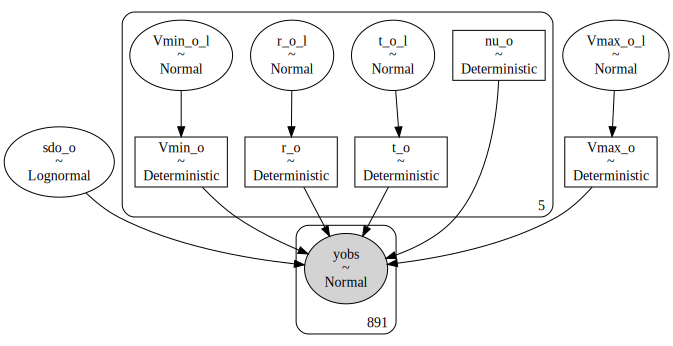

In [15]:
pm.model_to_graphviz(fit_o_up)

In [16]:
if(sample):
    with fit_o_up:
        trace_o_up=pm.sample(start={'Vmax_o_l':np.log(150.),'sdo':0.5})
    pm.save_trace(trace_o_up,'traces/trace_oc_ave',overwrite=True)
else:
    trace_o_up = pm.load_trace('traces/trace_oc_ave',fit_o_up)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sdo_o, Vmin_o_l, t_o_l, r_o_l, Vmax_o_l]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The number of effective samples is smaller than 25% for some parameters.


OSError: Cautiously refusing to overwrite the already existing trace_o_ave! Please supply a different directory, or set `overwrite=True`

'traces/trace_oc_ave'

### Fit the Nurse cell model

In [46]:
xn = df['pos'].values.copy()
yn = df['Ns_size'].values.copy()


treatday = df['i_treatday']
ntreatday = len(np.unique(treatday))


with pm.Model() as fit_n_up:
    vdict = {}
    Vmax_n_l  = pm.Normal( 'Vmax_n_l',mu=np.log(90),sd=0.2)  # hyper prior for grand mean  
    #Vmax_n_l=pmu.add_1level_hierarchy('Vmax_n_l',vdict,np.log(90), 0.2, 0.2, nind)
    Vmax_n = pm.Deterministic('Vmax_n',tt.exp(Vmax_n_l))        

    #a0_l    = pmu.add_2level_hierarchy('a0_l',vdict, np.log(0.5),0.2, 0.1,0.1, ind_in_treatday )
    r_n_l = pm.Normal('r_n_l',np.log(3),0.2,shape=ntreatday)
    r_n      = pm.Deterministic('r_n',tt.exp(r_n_l))        
  
    #t0_l = pmu.add_2level_hierarchy('t0_l',vdict, np.log(5),0.2,0.1,0.1, ind_in_treatday )
    t_n_l = pm.Normal('t_n_l',mu=6,sd=4,shape=ntreatday)
    t_n   = pm.Deterministic('t_n',tt.exp(t_n_l)-2)

    
    #a1_l    = pmu.add_2level_hierarchy('a1_l',vdict, np.log(1.5),0.2, 0.075,0.075, ind_in_treatday )
    #a1_l    = pmu.add_1level_hierarchy('a1_l',vdict, 0,3, 1, nind)
    #a1_l  =pm.TruncatedNormal('a1_l', mu=np.log(1.5),sd=0.2,upper=np.log(4),shape=nind) 
    r_d_l = pm.Normal('r_d_l',np.log(0.85),sd=0.2,shape=ntreatday)
    r_d   = pm.Deterministic( 'r_d',tt.exp(r_d_l))
    #a1      = pm.Deterministic('a1',tt.exp(a1_l))        
  
    #t1_l = pmu.add_1level_hierarchy('t1_l',vdict, -1,6,4, nind )
    t_d_l = pm.Normal('t_d_l',mu=-1,sd=4,shape=ntreatday)
    t_d   = pm.Deterministic('t_d',t_d_l)
 
    #Vmin_n_l = pmu.add_1level_hierarchy('Vmin_n_l',vdict, np.log(10), 0.4, 0.05, nind )
    Vmin_n_l = pm.Normal( 'Vmin_n_l',mu=np.log(10), sd=0.2,shape=ntreatday)
    Vmin_n   = pm.Deterministic('Vmin_n',tt.exp(Vmin_n_l))
    
    nu_n = pm.Deterministic('nu_n',tt.ones(ntreatday))
    nu_d = pm.Deterministic('nu_d',tt.ones(ntreatday))
 
    fn    = bu.rise_and_fall_r(xn, Vmax_n, t_n[treatday],r_n[treatday],nu0[treatday], \
                                           t_d[treatday],r_d[treatday],nu1[treatday],Vmin_n[treatday]) 
    
    sdo_n = pm.HalfCauchy('sdo_n', 20.)
    yobs_n = pm.Normal('yn',fn,sd=sdo_n, observed = yn)

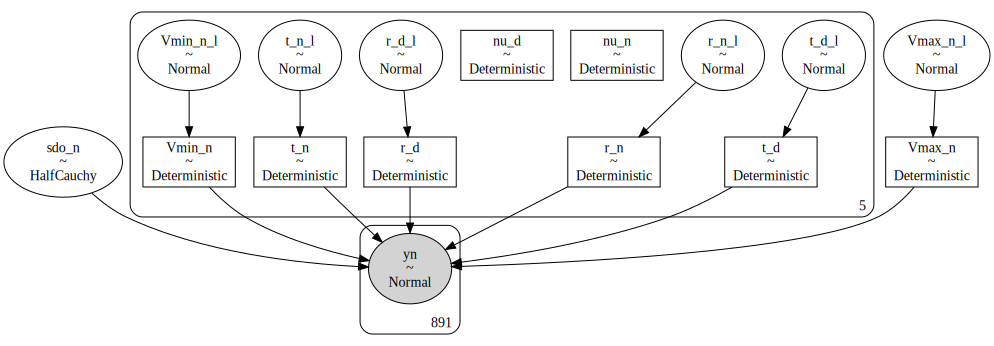

In [47]:
pm.model_to_graphviz(fit_n_up)

In [48]:
if(sample):
    with fit_n_up:
        trace_n_up=pm.sample(start={'Vmax_n_l':np.log(150.),'sdo_n':0.5})
    pm.save_trace(trace_n_up,'traces/trace_ns_ave',overwrite=True)
else:
    trace_n_up = pm.load_trace('traces/trace_ns_ave',fit_n_up)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sdo_n, Vmin_n_l, t_d_l, r_d_l, t_n_l, r_n_l, Vmax_n_l]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
def plot_exp_unit( ax, df, iexp, alpha=1):
    mask = df['i_ind']==iexp
    dft = df[mask]
    x = dft['pos'].values
    yo = dft['Oc_size'].values
    yn = dft['Ns_size'].values   
    xp = np.linspace(0,max(x)+2,40)
    ax.plot(-x,yo,'-',label='oocyte',color='red',alpha=alpha)
    ax.plot(-x,yn,'-',label='nurse',color='blue',alpha=alpha)
    locs = ax.get_xticks()
    ax.set_xticklabels(["{:d}".format(int(abs(x))) for x in locs])

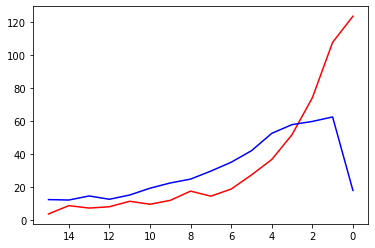

In [21]:
fig,ax = plt.subplots(1,1)
plot_exp_unit( ax,df,1)

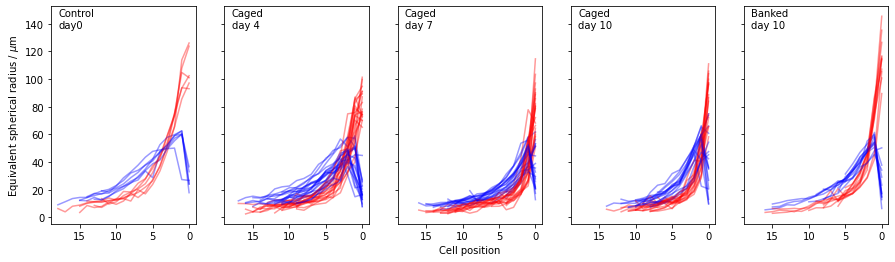

In [22]:
importlib.reload(bu)
fig,axs = plt.subplots(1,5,figsize=(15,4),sharex=True,sharey=True)
ind_in_treatday = indexTools.embeded_index(df,'i_ind','i_treatday')
labels ="Control\nday0;Caged\nday 4;Caged\nday 7;Caged\nday 10;Banked\nday 10".split(';')
for j in range(5):
    ax=axs[j]
    ax.annotate(labels[j],(0.05,0.90),xycoords='axes fraction')
    for ind in np.argwhere(ind_in_treatday==j).flatten():
        plot_exp_unit(ax,df,ind,alpha=0.4)
    #bu.posterior_comp(ax,df,trace_o_up,j,code='o',ptype='median',color='black',index='i_treatday')
    #bu.posterior_comp(ax,df,trace_n_up,j,code='n',ptype='median',color='black',index='i_treatday')
axs[0].set_ylabel(r"Equivalent spherical radius / $\mu$m")
axs[2].set_xlabel("Cell position")
plt.savefig('averaged_model/compare_median.pdf')

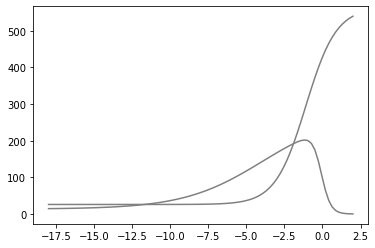

In [51]:
fig,ax = plt.subplots(1,1)
bu.posterior_comp_r(ax,df,trace_o_up,j,code='o',ptype='median',color=colors[j],index='i_treatday')

bu.posterior_comp_r(ax,df,trace_n_up,j,code='n',ptype='median',color=colors[j],index='i_treatday')

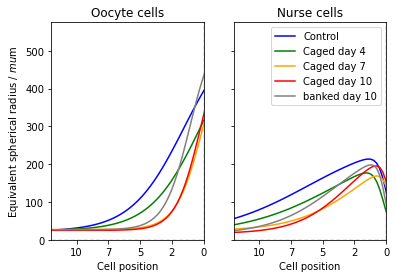

In [61]:
import matplotlib.lines as mlines

fig,axs = plt.subplots(1,2,sharex=True,sharey=True)
colors ='blue green orange red grey'.split()
labels ="Control;Caged day 4;Caged day 7;Caged day 10;banked day 10".split(';')


lines_leg =[ mlines.Line2D([], [], color=colors[j], label=labels[j]) for j in range(5)]


ax=axs[0]
ax.set_title("Oocyte cells")
ax.axvline(0,ls='--',lw=1.2,color='k')
ax.axhline(0,ls='--',lw=1.2,color='k')
for j in range(5):
    bu.posterior_comp_r(ax,df,trace_o_up,j,code='o',ptype='median',color=colors[j],index='i_treatday')


ax=axs[1]
ax.set_title("Nurse cells")
ax.axvline(0,ls='--',lw=1.2,color='k')
ax.axhline(0,ls='--',lw=1.2,color='k')
for j in range(5):
    bu.posterior_comp_r(ax,df,trace_n_up,j,code='n',ptype='median',color=colors[j],index='i_treatday')  
ax.legend(handles = lines_leg)

ax.set_xlim(-12,0)
ax.set_ylim(bottom=0)
locs = ax.get_xticks()
ax.set_xticklabels([int(abs(x)) for x in locs]);
axs[0].set_xlabel("Cell position")
axs[1].set_xlabel("Cell position")
axs[0].set_ylabel(r"Equivalent spherical radius / $mu$m")


plt.savefig('averaged_model/compare_median_models.pdf')

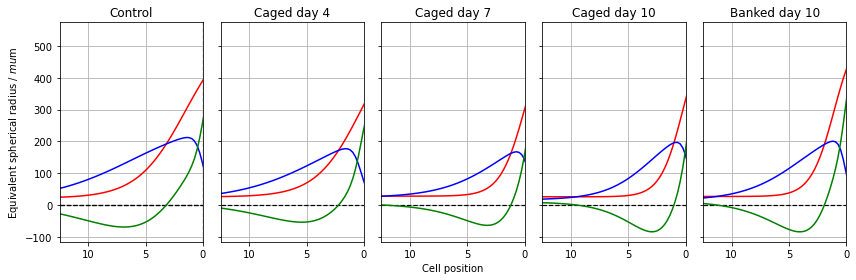

In [78]:
import matplotlib.lines as mlines

import pandas as pd
df_size=pd.DataFrame(columns='treatday V_oc_max V_oc_min V_ns_max V_ns_min V_eq eq_pos oc_thresh_pos ns_thresh_pos'.split())
df_size.set_index('treatday',inplace=True)

fig,axs = plt.subplots(1,5,sharex=True,sharey=True,figsize=(12,4))
colors ='blue green orange red grey'.split()
labels ="Control;Caged day 4;Caged day 7;Caged day 10;Banked day 10".split(';')

#lines_leg =[ mlines.Line2D([], [], color=colors[j], label=labels[j]) for j in range(5)]
#ax.legend(handles = lines_leg)


ax=axs[0]

ax.axvline(0,ls='--',lw=1.2,color='k')
ax.axhline(0,ls='--',lw=1.2,color='k')
    

ax=axs[1]
ax.set_title("Nurse cells")
#ax.axvline(0,ls='--',lw=1.2,color='k')
#ax.axhline(0,ls='--',lw=1.2,color='k')

thresh=1.10
V_oc_mins = np.median(trace_o_up['Vmin_o'],axis=0)
V_ns_mins = np.median(trace_n_up['Vmin_n'],axis=0)
for j in range(5):
    ax = axs[j]
    label = labels[j]
    ax.set_title(label)

    ax.axhline(0,ls='--',lw=1.2,color='k')
    bu.posterior_comp_r(ax,df,trace_o_up,j,code='o',ptype='median',color='red',index='i_treatday')
    x = ax.get_lines()[-1].get_xdata()
    yo = ax.get_lines()[-1].get_ydata()
    bu.posterior_comp_r(ax,df,trace_n_up,j,code='n',ptype='median',color='blue',index='i_treatday')  
    yn = ax.get_lines()[-1].get_ydata()
    ax.plot(x,yo-yn,color='Green')
    
    

    imin = np.argmin(yn<yo)
    #ax.plot(x[imin],0,'o',color='magenta')
    
    
    df_size.loc[label,'V_oc_max']=np.max(yo)
    df_size.loc[label,'V_oc_min']=np.min(yo)
    df_size.loc[label,'V_ns_max']=np.max(yn)
    df_size.loc[label,'V_ns_min']=np.min(yn)
    df_size.loc[label,'V_eq']    = (yo+yn)[imin]/2.
    df_size.loc[label,'eq_pos']=-x[imin]
    
    ithresh = len(x)-1-np.argmax( (yo[::-1] >thresh*V_oc_mins[j]))
    #ithresh = np.argmax( yo<thresh*V_oc_mins[j])

    df_size.loc[label,'oc_thresh_pos']=-x[ithresh]
    #ax.plot(x[ithresh],yo[ithresh],'^',color='red')
    
    ithresh = len(x)-1-np.argmax( (yn[::-1] >thresh*V_ns_mins[j]))
    #print(ithresh,x[ithresh],yn[ithresh])
    df_size.loc[label,'ns_thresh_pos']=-x[ithresh]
    #ax.plot(x[ithresh],yn[ithresh],'^',color='blue')
    ax.grid()

ax.set_xlim(-12.5,0)
#ax.set_ylim()
locs = ax.get_xticks()
ax.set_xticklabels([int(abs(x)) for x in locs]);
axs[2].set_xlabel("Cell position")
axs[0].set_ylabel(r"Equivalent spherical radius / $mu$m")
plt.tight_layout()
plt.savefig("averaged_model/compare_median_panel.pdf")


In [69]:
trace_n_up.varnames

['Vmax_n_l',
 'r_n_l',
 't_n_l',
 'r_d_l',
 't_d_l',
 'Vmin_n_l',
 'sdo_n_log__',
 'Vmax_n',
 'r_n',
 't_n',
 'r_d',
 't_d',
 'Vmin_n',
 'nu_n',
 'nu_d',
 'sdo_n']

In [53]:
def get_crossing_metrics(x,ylow,yhigh):
    '''returns the location and size of ylow crosses yhigh where yo=yn'''
    if( np.all(x[1:]-x[:-1]<0) ): # increasing x
        return get_crossing_metrics(x[::-1],ylow[::-1],yhigh[::-1])
    # find the crossing point
    
    diffs = ylow-yhigh
    imin = np.argmin( diffs<0)
    if( imin==0 ):
        return x[imin],ylow[imin]        

    d1,d2 = diffs[imin],diffs[imin-1] # difference each side
    x1,x2 = x[[imin,imin-1]]
    y1,y2 = ylow[[imin,imin-1]]
    f = d2/(d2-d1)
    xc,yc = f*x1+(1-f)*x2, f*y1+(1-f)*y2      
    return xc,yc

In [54]:
variables = 'V_oc_min V_oc_max V_oc_last oc_thresh_pos V_ns_min V_ns_max V_ns_last ns_thresh_pos V_ns_diff eq_pos V_eq'.split()
treats= 'control,caged day4,caged day 7,caged day 10,banked'.split(',')
mindex=pd.MultiIndex.from_product([variables,treats])

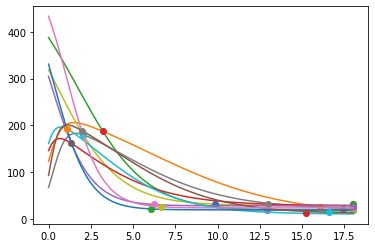

In [74]:
percs=[2.5,35,50,75,97.5]
df_av_stats = pd.DataFrame(columns=list(map(str,percs)),index=mindex,dtype=float)

X = np.linspace(0,18,101)
for itreat,treat in enumerate(treats):
    Yo=bu.posterior_draws_r(trace_o_up,itreat,'o',X,nsamp=1000)
    Yn=bu.posterior_draws_r(trace_n_up,itreat,'n',X,nsamp=1000)

    Yo_min = np.min(Yo,axis=1)
    Yn_min = np.min(Yn,axis=1)

    Xnc = np.zeros_like(Yo_min)  # OOcytr nurse crossing points
    Ync = np.zeros_like(Yo_min)

    Xot = np.zeros_like(Yo_min)
    Yot = np.zeros_like(Yo_min)

    Xnt = np.zeros_like(Yo_min)
    Ynt = np.zeros_like(Yo_min)



    for i in range(len(Yo_min)):
        Xnc[i],Ync[i]=get_crossing_metrics(X,Yn[i],Yo[i])


        Xot[i],Yot[i]=get_crossing_metrics(X,Yo_min[i]*1.10*np.ones_like(X),Yo[i])

        Xnt[i],Ynt[i]=get_crossing_metrics(X,Yn_min[i]*1.10*np.ones_like(X),Yn[i])

        if(i==34):
            plt.plot(X[-1],Yo_min[i]*1.1,'o')


            plt.plot(X,Yn[i])
            plt.plot(X,Yo[i])
            plt.plot(Xnc[i],Ync[i],'o')

            plt.plot(Xot[i],Yot[i],'o')
            plt.plot(Xnt[i],Ynt[i],'o')
    df_av_stats.loc['V_oc_min',treat]  =np.percentile(np.min(Yo,axis=1),percs)
    df_av_stats.loc['V_oc_min',treat]  =np.percentile(np.min(Yo,axis=1),percs)
    df_av_stats.loc['V_oc_max',treat]  =np.percentile(np.max(Yo,axis=1),percs)
    df_av_stats.loc['V_oc_last',treat] =np.percentile(Yo [:,0],percs)
    df_av_stats.loc['oc_thresh_pos',treat]     =np.percentile(Xot,percs)

    df_av_stats.loc['V_ns_min', treat] =np.percentile(np.min(Yn,axis=1),percs)
    df_av_stats.loc['V_ns_max', treat] =np.percentile(np.max(Yn,axis=1),percs)
    df_av_stats.loc['V_ns_last',treat] =np.percentile(Yn [:,0],percs)
    df_av_stats.loc['ns_thresh_pos',treat] =np.percentile(Xnt,percs)
    df_av_stats.loc['V_ns_diff',treat] =np.percentile(np.max(Yn,axis=1)-Yn[:,0],percs)

    df_av_stats.loc['eq_pos',   treat] =np.percentile(Xnc,percs)
    df_av_stats.loc['V_eq',     treat] =np.percentile(Ync,percs)


In [258]:
df_av_stats.round(3).to_csv('averaged_size_stats_uncert.csv')
df_av_stats

2.5          35          50          75  \
V_oc_min      control         7.565564    9.255745    9.672186   10.456147   
              caged day4      6.897492    8.074617    8.324296    8.746009   
              caged day 7     7.555112    8.523410    8.731835    9.149566   
              caged day 10    7.954203    8.992246    9.281159    9.744606   
              banked          9.344986   10.763444   11.069691   11.702143   
V_oc_max      control       108.741910  112.120874  113.047770  114.386532   
              caged day4     81.518136   83.666677   84.249429   85.148880   
              caged day 7    74.839946   77.325000   77.911612   78.939383   
              caged day 10   81.534978   84.440704   85.074751   86.167370   
              banked        108.779206  112.230210  113.119912  114.306791   
V_oc_last     control       108.741910  112.120874  113.047770  114.386532   
              caged day4     81.518136   83.666677   84.249429   85.148880   
              caged day 7    74.839946   77.325000   77.911612   78.939383   
              caged day 10   81.534978   84.440704   85.074751   86.167370   
              banked        108.779206  112.230210  113.119912  114.306791   
oc_thresh_pos control        10.358600   11.479014   11.734338   12.245566   
              caged day4      9.157652    9.976404   10.183092   10.551066   
              caged day 7     4.568651    4.989415    5.108639    5.351080   
              caged day 10    4.338849    4.759412    4.888972    5.120583   
              banked          5.201779    5.779789    5.932912    6.196422   
V_ns_min      control         8.931463   11.447485   12.170692   13.568357   
              caged day4      9.558116   11.377573   11.849073   12.702336   
              caged day 7     8.796145   10.286531   10.642712   11.218351   
              caged day 10    8.452026   10.318735   10.778390   11.558716   
              banked          7.381878    9.482842   10.090531   11.029068   
V_ns_max      control        54.256571   56.768232   57.416504   58.578784   
              caged day4     43.107658   44.695999   45.100198   45.750884   
              caged day 7    42.493528   44.800368   45.395967   46.433386   
              caged day 10   49.539058   51.536100   52.234607   53.377133   
              banked         48.996494   51.231732   51.817186   52.908855   
V_ns_last     control        21.530818   25.919795   26.966971   28.913497   
              caged day4     14.110137   16.642247   17.234072   18.259752   
              caged day 7    32.734796   35.068351   35.687075   36.764596   
              caged day 10   34.137133   36.771067   37.441516   38.743753   
              banked         26.481338   29.667069   30.394483   31.636411   
ns_thresh_pos control        12.034279   14.104774   14.583012   15.391974   
              caged day4     10.392002   12.363849   12.809792   13.569123   
              caged day 7     7.551355    8.850960    9.283524   10.035984   
              caged day 10    7.006803    8.195734    8.469546    9.030285   
              banked          9.099399   10.848930   11.273096   12.196795   
V_ns_diff     control        23.239479   29.258243   30.575651   32.800799   
              caged day4     23.884908   27.079625   27.853199   29.133131   
              caged day 7     5.626058    8.855194    9.650406   11.009039   
              caged day 10   10.668341   13.879767   14.774834   16.330549   
              banked         17.064781   20.552442   21.447048   23.032559   
eq_pos        control         2.969717    3.238329    3.300131    3.422756   
              caged day4      1.954875    2.125338    2.168155    2.251364   
              caged day 7     0.856467    0.978047    1.007953    1.064648   
              caged day 10    0.713483    0.822707    0.848995    0.892081   
              banked          1.648667    1.807740    1.846964    1.910793   
V_eq          control        46.168057   49.554397   50.1

In [212]:
df_av_stats.loc['V_oc_min','control']

2.5     NaN
35      NaN
50      NaN
75      NaN
97.5    NaN
Name: (V_oc_min, control), dtype: object

In [82]:
X = np.linspace(0,12,61)
funcs=bu.posterior_draws( trace_o_up,'o',X,nsamp=1000)
np.percentile(funcs[:,-1],[2.5,50,97.5])

array([ 8.89665834, 10.4813444 , 12.11742609])

In [108]:
np.shape(trace_o_up.get_values('Vmax_o'))

(2000,)

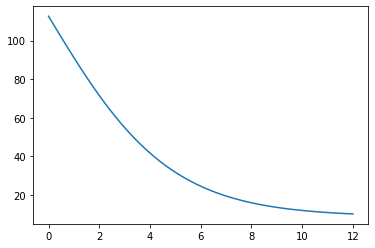

In [97]:
plt.plot(X,funcs[4])

112.92690803471453

In [14]:

df_size.to_csv('averaged_size_stats.csv')
df_size

,V_oc_max,V_oc_min,V_ns_max,V_ns_min,V_eq,eq_pos,oc_thresh_pos,ns_thresh_pos
treatday,,,,,,,,
Control,113.787,9.58638,58.0919,11.4354,49.9092,3.36842,11.7895,14.9474
Caged day 4,84.1735,8.42603,45.2443,11.608,42.9252,2.2967,10.2308,12.9451
Caged day 7,77.5673,8.76897,45.0043,10.5304,42.948,1.03448,5.17241,9.10345
Caged day 10,85.4944,9.27155,52.4925,10.718,48.9399,1.01266,4.86076,8.3038
Banked day 10,113.291,10.9928,52.2632,10.1686,46.7594,1.86207,5.58621,11.5862


,treat,day,rep,string,pos,Oc_size,Ns_size,i_ind,ucode,i_treatday,treatday,i_treat
0,cont,0,1,1,0,93.007768,26.696400,0,cont_0_1_1,0,cont_0,0
1,cont,0,1,1,1,93.697638,27.307331,0,cont_0_1_1,0,cont_0,0
2,cont,0,1,1,2,73.226346,50.065922,0,cont_0_1_1,0,cont_0,0
3,cont,0,1,1,3,58.799506,49.666221,0,cont_0_1_1,0,cont_0,0
4,cont,0,1,1,4,44.743530,48.777769,0,cont_0_1_1,0,cont_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
856,banked,10,4,5,2,41.471191,47.598980,70,banked_10_4_5,4,banked_10,2
857,banked,10,4,5,3,27.369118,39.160255,70,banked_10_4_5,4,banked_10,2
858,banked,10,4,5,4,20.922700,33.824676,70,banked_10_4_5,4,banked_10,2
859,banked,10,4,5,5,17.006383,28.096500,70,banked_10_4_5,4,banked_10,2


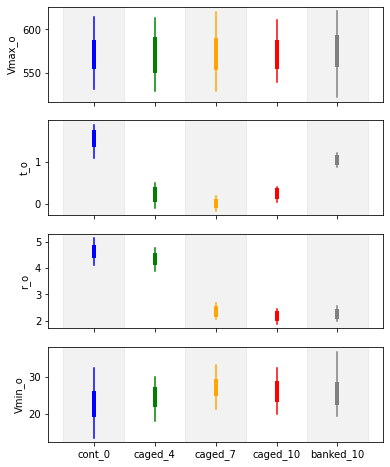

In [76]:
bu.compare_groups(df,trace_o_up,'Vmax_o t_o r_o Vmin_o'.split())
plt.savefig('averaged_model/oocyte_params.pdf')

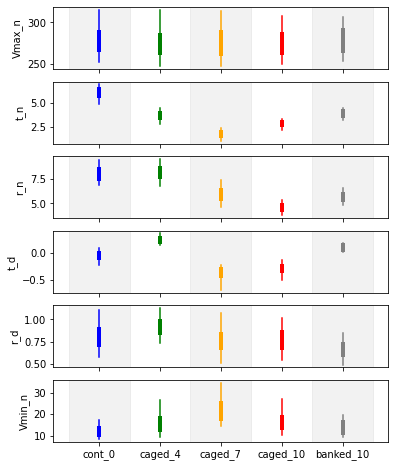

In [77]:
bu.compare_groups(df,trace_n_up,'Vmax_n t_n r_n t_d r_d Vmin_n'.split())
plt.savefig('averaged_model/nurse_params.pdf')

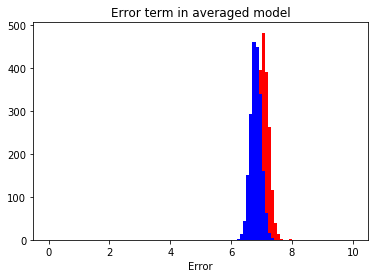

In [87]:
bins=np.linspace(0,10,101)
plt.hist(trace_o_up.get_values('sdo_o'),bins=bins,color='red');
plt.hist(trace_n_up.get_values('sdo_n'),bins=bins,color='blue');
plt.title("Error term in averaged model")
plt.xlabel('Error')
plt.savefig('averaged_model/error_term.pdf')